# Create a pretty figure with latex.<br>


In [1]:
# @title ##### Installing stuff... (it may take a few seconds)

%%capture
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

import numpy as np
from matplotlib import pyplot

In [12]:
import pandas as pd
exper = pd.read_csv("https://raw.githubusercontent.com/emartineznunez/latex/master/exp.csv")
m3c_ts = pd.read_csv("https://raw.githubusercontent.com/emartineznunez/latex/master/M3C_TS.csv")

HTTPError: HTTP Error 404: Not Found

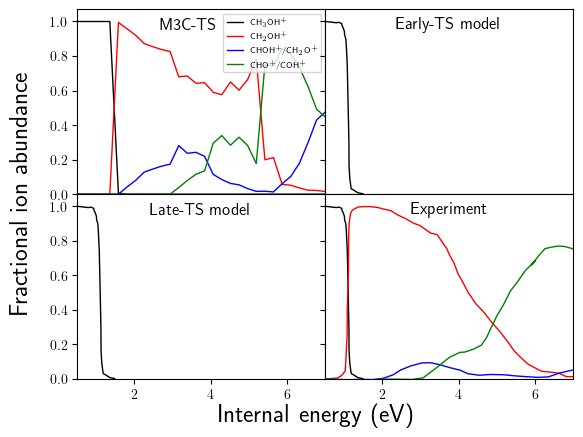

In [11]:
# @title ##### Figure


px = exper['parent_x']
py = exper['parent_y']

x = m3c_ts['X']
parent = m3c_ts['parent']
ch2oh_m3cts = m3c_ts['ch2oh']
ch2o_m3cts = m3c_ts['ch2o']
hco_m3cts = m3c_ts['hco']

ch2ohx = exper['ch2oh_x']
ch2ohy = exper['ch2oh_y']

chohx = exper['choh_x']
chohy = exper['choh_y']

chox = exper['cho_x']
choy = exper['cho_y']

pyplot.rcParams['text.usetex'] = True

fig = pyplot.figure()
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

ax1.plot(x,parent,'-',color='black',label='CH$_3$OH$^+$',mfc='none',linewidth=1.0)
ax1.plot(x,ch2oh_m3cts,'-',color='red',label='CH$_2$OH$^+$',mfc='none',linewidth=1.0)
ax1.plot(x,ch2o_m3cts,'-',color='blue',label='CHOH$^+$/CH$_2$O$^+$',mfc='none',linewidth=1.0)
ax1.plot(x,hco_m3cts,'-',color='green',label='CHO$^+$/COH$^+$',mfc='none',linewidth=1.0)
ax2.plot(px-10.5,py,'-',color='black',label='CH$_3$OH$^+$',mfc='none',linewidth=1.0)
ax3.plot(px-10.5,py,'-',color='black',label='CH$_3$OH$^+$',mfc='none',linewidth=1.0)
ax4.plot(px-10.5,py,'-',color='black',label='CH$_3$OH$^+$',mfc='none',linewidth=1.0)
ax4.plot(ch2ohx-10.5,ch2ohy,'-',color='red',label='CH$_2$OH$^+$',mfc='none',linewidth=1.0)
ax4.plot(chohx-10.5,chohy,'-',color='blue',label='CHOH$^+$/CH$_2$O$^+$',mfc='none',linewidth=1.0)
ax4.plot(chox-10.5,choy,'-',color='green',label='CHO$^+$/COH$^+$',mfc='none',linewidth=1.0)
ax1.set_xlim(0.5,7)
ax2.set_xlim(0.5,7)
ax3.set_xlim(0.5,7)
ax4.set_xlim(0.5,7)
ax1.set_ylim(0,1.07)
ax2.set_ylim(0,1.07)
ax3.set_ylim(0,1.07)
ax4.set_ylim(0,1.07)
ax1.legend(fontsize=6,loc="upper right")
ax1.set_title('M3C-TS',x=0.45, y=0.9,pad=-1)
ax2.set_title('Early-TS model',y=0.9,pad=-1)
ax3.set_title('Late-TS model',y=0.9,pad=-1)
ax4.set_title('Experiment',y=0.9,pad=-1)

for ax in fig.get_axes():
    ax.label_outer()

fig.supylabel('Fractional ion abundance',fontsize=18)
fig.supxlabel('Internal energy (eV)',fontsize=18)
pyplot.savefig('comp2.svg')
pyplot.show()